In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, math
from datetime import datetime
import seaborn as sns
import matplotlib.cm as cm

from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Import data

In [2]:
dat = pd.read_csv("../data/ATP.csv")

# convert date as datatime

In [3]:
dat['date'] = dat.tourney_date.apply(lambda t: datetime.strptime(str(t), '%Y%m%d'))

# change format of initial dataframe

In [4]:
colnames = dict()
colnames['type1'] = ['1stIn', '1stWon', '2ndWon', 'SvGms', 'ace', 'bpFaced', 'bpSaved', 'df', 'svpt']
colnames['type2'] = ['age', 'entry', 'hand', 'ht', 'id', 'ioc', 'name', 'rank', 'rank_points', 'seed']
colnames['type3'] = ['best_of', 'draw_size', 'match_num', 'minutes', 'round', 'score', 'surface', 'tourney_date',
                     'tourney_id', 'tourney_level', 'tourney_name', 'date']

In [5]:
df = pd.DataFrame()
mat = []
for i in dat.index:
    row = []
    for col in colnames['type3']:
        row.append(dat[col][i])
    if i % 2 == 0: #j0
        # j0=loser, j1=winner
        for col in colnames['type1']:
            row.append(dat['l_'+col][i])
        for col in colnames['type2']:
            row.append(dat['loser_'+col][i])
        for col in colnames['type1']:
            row.append(dat['w_'+col][i])
        for col in colnames['type2']:
            row.append(dat['winner_'+col][i])
        row.append(1) #target winner --> j1
    else: #j1
        # j0=winner, j1=loser
        for col in colnames['type1']:
            row.append(dat['w_'+col][i])
        for col in colnames['type2']:
            row.append(dat['winner_'+col][i])
        for col in colnames['type1']:
            row.append(dat['l_'+col][i])
        for col in colnames['type2']:
            row.append(dat['loser_'+col][i])
        row.append(0) #target winner --> j0
    mat.append(row)

In [6]:
colDataFrame = colnames['type3']
for col in colnames['type1']:
    colDataFrame.append('j0_'+col)
for col in colnames['type2']:
    colDataFrame.append('j0_'+col)
for col in colnames['type1']:
    colDataFrame.append('j1_'+col)
for col in colnames['type2']:
    colDataFrame.append('j1_'+col)
colDataFrame.append("target")

In [7]:
df = pd.DataFrame(columns=colDataFrame, data=mat)

In [8]:
df.to_csv("../data/ATP_.csv", sep=";", index=False)

# Exploration of data

In [82]:
dateparse = lambda x:datetime.strptime(x,'%Y-%m-%d').date()

In [83]:
df = pd.read_csv("../data/ATP_.csv", sep=";")
print("nRows : {}, nCols : {}".format(df.shape[0], df.shape[1]))

nRows : 169690, nCols : 51


In [85]:
df['date'] = df['date'].apply(dateparse)

In [42]:
dfe = df.copy()

The first rankings were published in August, 23rd 1973, so we can delete all row without rank as this value seems to be important for the bookmakers !

In [43]:
dfe = dfe.loc[np.invert(dfe.j0_rank.isna()) & np.invert(dfe.j1_rank.isna())]
dfe = dfe.loc[np.invert(dfe.j0_rank_points.isna()) & np.invert(dfe.j1_rank_points.isna())]
dfe = dfe.loc[np.invert(dfe.surface.isna())]
dfe = dfe.loc[np.invert(dfe.j0_age.isna()) & np.invert(dfe.j1_age.isna())]
dfe = dfe.loc[dfe.surface != "None"]

In [44]:
print("There are {} matches since {}".format(dfe.shape[0], dfe.date[0:1]))
print("There are {} different players".format(len(list(set(dfe.j0_name + dfe.j1_name)))))

There are 92271 matches since 73120   1990-01-01
Name: date, dtype: datetime64[ns]
There are 62519 different players


In [45]:
dfe.surface.unique()

array(['Hard', 'Grass', 'Carpet', 'Clay'], dtype=object)

In [46]:
count_surface

,surface,Count
0,Carpet,7415
2,Grass,9134
1,Clay,31048
3,Hard,44674


Text(0.5,1,'Surface')

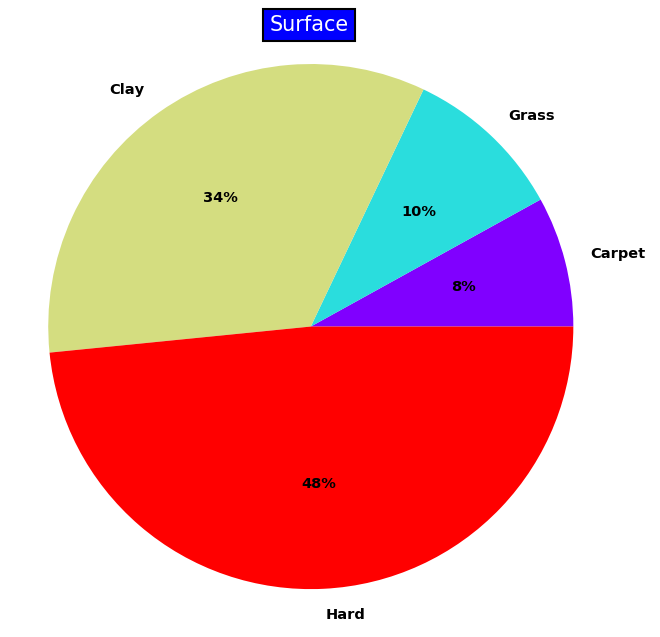

In [75]:
# pie chart of surface
count_surface = dfe[["tourney_id", "surface"]]
count_surface = count_surface.groupby(["surface"]).agg('count')
count_surface.reset_index(inplace=True)
count_surface.columns=["surface","Count"]
count_surface.sort_values("Count", inplace=True)

x = np.arange(count_surface.shape[0])
ys = [i+x+(i*x)**2 for i in range(count_surface.shape[0])]
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(5,5), dpi=150)
labels=count_surface.surface.values

sizes=count_surface.Count.values

explode = [0.9 if sizes[i] < 1000 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0, textprops={'fontsize': 7})
ax.axis('equal')
ax.set_title('Surface', bbox={'facecolor':'blue', 'pad':3}, color = 'w', fontsize=10)

In [91]:
dfe.groupby(["surface","target"])["j0_rank_points","j1_rank_points"].agg('mean')

j0_rank_points  j1_rank_points
surface target                                
Carpet  0          1158.680702      830.936842
        1           819.912399     1163.710512
Clay    0          1214.897490      780.399807
        1           779.875806     1198.669267
Grass   0          1345.366784      794.533304
        1           796.660394     1368.966958
Hard    0          1497.929218      904.962883
        1           905.214567     1522.124341

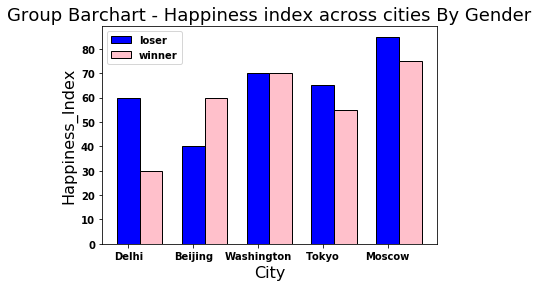

In [86]:
city=['Delhi','Beijing','Washington','Tokyo','Moscow']
Gender=['loser','winner']
pos = np.arange(len(city))
bar_width = 0.35
Happiness_Index_Male=[60,40,70,65,85]
Happiness_Index_Female=[30,60,70,55,75]
 
plt.bar(pos,Happiness_Index_Male,bar_width,color='blue',edgecolor='black')
plt.bar(pos+bar_width,Happiness_Index_Female,bar_width,color='pink',edgecolor='black')
plt.xticks(pos, city)
plt.xlabel('City', fontsize=16)
plt.ylabel('Happiness_Index', fontsize=16)
plt.title('Group Barchart - Happiness index across cities By Gender',fontsize=18)
plt.legend(Gender,loc=2)
plt.show()

In [92]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(dfe.surface)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

onehot_encoder.feature_indices_

[3 3 3 ... 1 1 1]


NameError: name 'OneHotEncoder' is not defined

In [93]:
# Binarize surface
df_surface = dfe.surface.str.get_dummies()
df_surface.head()

,Carpet,Clay,Grass,Hard
73120,0,0,0,1
73121,0,0,0,1
73122,0,0,0,1
73123,0,0,0,1
73124,0,0,0,1


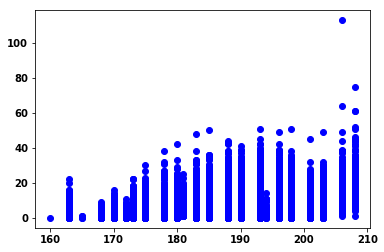

In [94]:
sum(dfe.j0_ace.isna())
_ = plt.scatter(dfe.j0_ht, dfe.j0_ace, c='blue')

# Model

In [95]:
class Model:
    def __init__(self,data,seed,random_sample):
        self.random_sample = random_sample
        self.seed = seed
        
        self.data = data.sample(frac=self.random_sample, replace=False, random_state=self.seed)
        
        self.lr=None
        self.pred_train=None
        self.pred_test=None
    def split(self, test_size):
        self.test_size = test_size
        train_X, test_X, train_y, test_y = train_test_split(self.data,self.data['target'], test_size = test_size, random_state=self.seed)
        self.train_X = train_X.drop(columns=['target'])
        self.test_X = test_X.drop(columns=['target'])
        self.train_y = train_y
        self.test_y = test_y
    def model_LR(self,n_jobs,cv,regul):
        self.regul = regul
        if regul=='none':
            n_iters = np.array([50, 200])
            model = linear_model.SGDClassifier(loss='log', random_state=0, penalty=self.regul)
            grid = GridSearchCV(estimator=model, param_grid=dict(n_iter=n_iters), scoring='roc_auc', n_jobs=n_jobs, cv=cv, verbose=1)
            grid.fit(self.train_X,self.train_y)
            self.grid = grid
        elif regul=='elasticnet':
            n_iters = np.array([50, 200])
            alphas = np.logspace(-5, 1, 5)
            l1_ratios = np.array([0, 0.15, 0.3, 0.4, 0.5, 0.6, 0.85, 1])
            model = linear_model.SGDClassifier(loss='log', random_state=0, penalty=self.regul,n_iter=100,max_iter=100)
            grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas,l1_ratio=l1_ratios), scoring='roc_auc', n_jobs=n_jobs, cv=cv, verbose=1)
            grid.fit(self.train_X,self.train_y)
            self.grid = grid
        return self.lr
    def model_GB(self,n_jobs,cv):
        param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,150,200],
                      'learning_rate':[0.1,0.2,0.5,0.7,0.9,1]}
        model = ensemble.GradientBoostingClassifier()
        grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', n_jobs=n_jobs, cv=cv, verbose=1)
        grid.fit(self.train_X,self.train_y)
        self.grid = grid
    def model_KNN(self,n_jobs,cv):
        param_grid = {'n_neighbors': np.arange(1,310,10)}
        model = neighbors.KNeighborsClassifier()
        grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', n_jobs=n_jobs, cv=cv, verbose=1)
        grid.fit(self.train_X,self.train_y)
        self.grid = grid
    def predict(self):
        self.pred_train = self.grid.best_estimator_.predict_proba(X=self.train_X)
        self.pred_test = self.grid.best_estimator_.predict_proba(X=self.test_X)
    def get_AUC(self):
        self.train_auc=metrics.roc_auc_score(y_score=self.grid.best_estimator_.predict_proba(X=self.train_X)[:,1], y_true=self.train_y)
        self.test_auc=metrics.roc_auc_score(y_score=self.grid.best_estimator_.predict_proba(X=self.test_X)[:,1], y_true=self.test_y)
        return (self.train_auc,self.test_auc)
    ### get contingency table + recall precision + roc curve !!!
    def boxplot(self):
        plt.figure()
        plt.subplot(1,2,1)
        sns.boxplot(x=self.train_y.values, y=self.grid.best_estimator_.predict_proba(X=self.train_X.values)[:,1])
        plt.title('Train')
        plt.subplot(1,2,2)
        sns.boxplot(x=self.test_y.values, y=self.grid.best_estimator_.predict_proba(X=self.test_X.values)[:,1])
        plt.title('Test')
        return plt
    def rocCurve(self):
        plt.figure()
        plt.subplot(1,2,1)
        fpr, tpr, thresholds = metrics.roc_curve(y_score=self.grid.best_estimator_.predict_proba(X=self.train_X)[:,1], y_true=self.train_y)
        plt.plot(fpr, tpr,'r')
        plt.plot([0,1],[0,1],'b')
        plt.title('Train, AUC: {}'.format(round(metrics.auc(fpr,tpr),3)))
        
        plt.subplot(1,2,2)
        fpr, tpr, thresholds = metrics.roc_curve(y_score=self.grid.best_estimator_.predict_proba(X=self.test_X)[:,1], y_true=self.test_y)
        plt.plot(fpr, tpr,'r')
        plt.plot([0,1],[0,1],'b')
        plt.title('Test, AUC: {}'.format(round(metrics.auc(fpr,tpr),3)))
        return plt
    def confusion(self,set_):
        if set_ == "train":
            res = metrics.confusion_matrix(y_true=self.train_y,y_pred=self.pred_train)
        elif set_ == "test":
            res = metrics.confusion_matrix(y_true=self.test_y,y_pred=self.pred_test)
        return res
    def getAccuracy(self):
        res=(metrics.accuracy_score(y_true=self.train_y,y_pred=self.pred_train),
            metrics.accuracy_score(y_true=self.test_y,y_pred=self.pred_test))
        return res
    def getClassificationReport(self,set_):
        if set_ == "train":
            res = metrics.classification_report(self.train_y, self.pred_train)
        elif set_ == "test":
            res = metrics.classification_report(self.test_y, self.pred_test)
        return res

In [110]:
dfm = dfe[["target","j0_rank_points","j1_rank_points","j0_age","j1_age","j0_bpSaved","j1_bpSaved"]]
dfm[df_surface.columns] = df_surface
dfm.dropna(inplace=True)

dfm.j0_rank_points = dfm.j0_rank_points.apply(lambda x: math.log(x))
dfm.j1_rank_points = dfm.j1_rank_points.apply(lambda x: math.log(x))
dfm.j0_age = dfm.j0_age.apply(lambda x: math.log(x))
dfm.j1_age = dfm.j1_age.apply(lambda x: math.log(x))

dfm.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

,target,j0_rank_points,j1_rank_points,j0_age,j1_age,j0_bpSaved,j1_bpSaved,Carpet,Clay,Grass,Hard
76863,0,7.304516,6.129050,3.242983,3.027231,5.0,2.0,0,0,0,1
76864,1,4.736198,5.916202,3.460095,3.070376,7.0,1.0,0,0,0,1
76865,0,6.148468,4.753590,3.231595,3.077312,2.0,4.0,0,0,0,1
76866,1,6.180017,6.218600,3.171784,3.251537,8.0,6.0,0,0,0,1
76867,0,4.955827,6.775366,2.981126,3.030134,2.0,4.0,0,0,0,1


In [111]:
lr = Model(data=dfm,seed=123,random_sample=0.5)
lr.split(0.35)
lr.model_LR(cv=4,n_jobs=8,regul="elasticnet")
lr.predict()

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:   24.4s finished
C:\Users\FEH-AZRAK\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


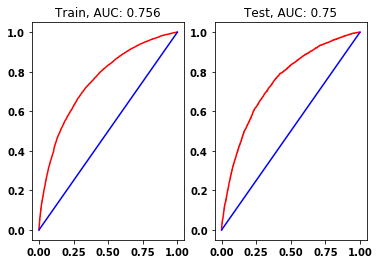

In [112]:
_ = lr.rocCurve()

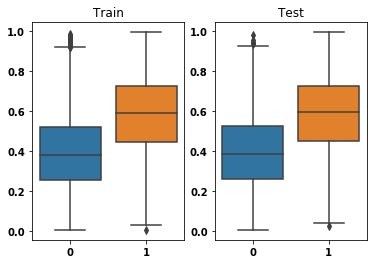

In [113]:
_ = lr.boxplot()

In [114]:
gb = Model(data=dfm,seed=123,random_sample=0.5)
gb.split(0.35)
gb.model_GB(cv=4,n_jobs=8)
gb.predict()

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 288 out of 288 | elapsed:  1.7min finished


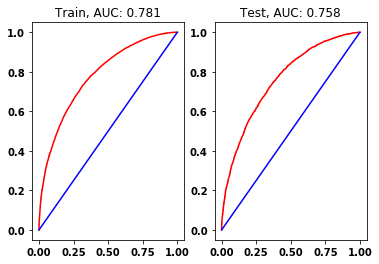

In [115]:
_ = gb.rocCurve()

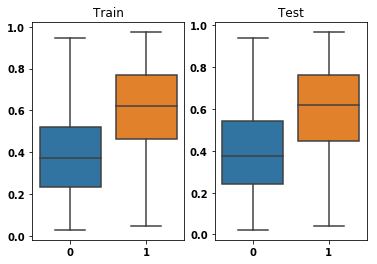

In [116]:
_ = gb.boxplot()

In [117]:
knn = Model(data=dfm,seed=123,random_sample=0.5)
knn.split(0.35)
knn.model_KNN(cv=4,n_jobs=8)
knn.predict()

Fitting 4 folds for each of 31 candidates, totalling 124 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   42.2s
[Parallel(n_jobs=8)]: Done 124 out of 124 | elapsed:  4.3min finished


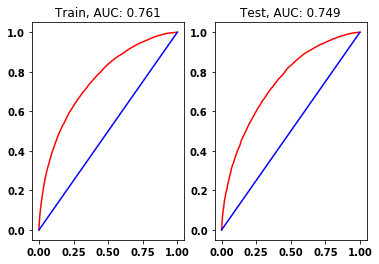

In [118]:
_ = knn.rocCurve()

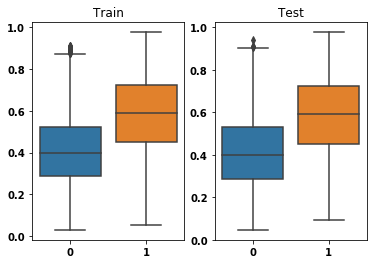

In [119]:
_ = knn.boxplot()

In [120]:
knn.grid.best_params_

{'n_neighbors': 171}